# Problem 2

The code from e.m.waves-ramp was altered to have a step instead of a ramp.
To change the ratio between the frequencies so that the density of the plasma is over-critical, and since the frequency of the laser omega0 is normalized with the plasma density, this frequency was changed for the various cases:

$$\omega_p/\omega=a => omega0=1/a$$

In [32]:
import em1d
import numpy as np
dt=0.028
tmax=170.

nx=8000
box=225

ndump=25
#Set up a plasma ramp
step_pos=180
#ver particles.h
density = em1d.Density( type = "step", start=step_pos)

#create an electron plasma species
sp_name="electrons"
ppc = 2 # Particles per cell
electrons = em1d.Species( sp_name, -1.0, ppc,density=density)

#initialize the arrays that will store the charge density and the field values
charge=[]
field=[]

# Diagnostics - this function is called at each time step of the simulation
def rep( sim ):
    if ( sim.n % ndump == 0 ):
        # Z component of electric field 
        field.append(np.array(sim.emf.Ez))
        
        # Charge density
        charge.append(np.array(electrons.charge()))

# Initialize simulation data
sim = em1d.Simulation( nx, box, dt, species=electrons, report = rep )

# Add laser pulse
sim.add_laser( em1d.Laser( start = 175.0, fall = 5.0,flat=145,rise=25, a0 = 0.000001, omega0 = 2, polarization = np.pi/2 ))

# Select open boundary conditions
sim.emf.bc_type = "open"

In [33]:
# Run the simulation
sim.run( tmax )


Running simulation up to t = 170 ...
n = 6072, t = 170.016
Done.


In [34]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from ipywidgets import interactive, widgets, fixed

#create the x dimension array
x=np.linspace(0,box,nx)

fig=plt.figure()
def f(it):      #this function is called everytime the slider is updated  
    ax=plt.gca()
    #plot the field
    ax.plot(x, field[it])
    ax.set_xlabel("$x_1\;[c/\omega_p]$")
    ax.set_ylabel("$E_3\;[m_e c \\omega_p e^{-1}]$")
    
    ax2=ax.twinx()
    #plot the electron density
    ax2.plot(x, -charge[it],c="C1")
    ax2.set_ylabel("$density\;[n_0]$")
    
    #update the horizontal limits of the plot by changing the following line
    ax2.set_xlim([100,250])
    ax.grid()
    ax.set_title("Iteration: {} /".format(it*ndump)+"Time: {:.4}[$1/\omega_p$] ".format(it*ndump*dt))

interactive_plot = interactive(f, it=(0, len(charge)))

interactive_plot

interactive(children=(IntSlider(value=121, description='it', max=243), Output()), _dom_classes=('widget-intera…

The E field for x>180 is given by:
$$E=E_0e^{-kz}\cos{\left(\omega t+\phi_t\right)}$$
For a fixed t, the points  where ffitted to the following function:
$$E=Ee^{-kz}$$
With this units:
$$k=\frac{\omega_p \beta}{c}$$

In [35]:
def Emfun(x, beta, L,E0):
    y=np.zeros(len(x))
    for i, xi in enumerate(x):
            y[i] = E0*np.exp(-beta*(xi-L))
    return y

In [36]:
#select the data that is currently plotted in the cells above
chrg_data=charge[interactive_plot.children[0].value]
emf_data =field[interactive_plot.children[0].value]

#find the position in the x-array where the ramp starts
itl=int(step_pos/box*nx)
xmin=x[itl]

xmax=box

#create the 3 sliders that control the selection of the transition region
sldr1=widgets.FloatSlider(value=(xmin+xmax)/2,min=xmin,max=xmax,orientation='horizontal',description='x-axis limit:')        
sldr2=widgets.FloatSlider(value=(xmin+sldr1.value)/2,min=xmin,max=sldr1.value,orientation='horizontal',description='turning point:')
sldr3=widgets.FloatSlider(value=(xmax-xmin)/nx*5,min=(xmax-xmin)/(nx-int(step_pos/box*nx)),max=(xmax-xmin)/10,orientation='horizontal',description='bar witdh:')


def regselect(maxx,itr,w,emf_data,datav,sldr): #this function is called everytime the sliders are moved  
    sldr.max=maxx
                    
    fig=plt.figure();
    plt.grid(alpha=0.6,linestyle='dashed')
    ax1=plt.gca()
    #plot the field values
    ax1.plot(x,emf_data,'.',c="darkorange");    
    ax1.set_xlim([xmin,maxx])
    ax1.set_xlabel("$x_1\;[c/\omega_p]$")
    ax1.set_ylabel("$E_3\;[m_e c \\omega_p e^{-1}]$")
    
    #plot the trasition region: a vertical line surrounded by a blue rectangle
    plt.axvline(x=itr,color='k')
    ymin=min(emf_data)
    ymax=max(emf_data)
    ylimin=ymin-(ymax-ymin)/10
    ylimax=ymax+(ymax-ymin)/10
    ax1.add_patch(patches.Rectangle((itr-w/2, ylimin),w,ylimax-ylimin,alpha=0.5))
    ax1.set_ylim([ylimin,ylimax])
    
    plt.show()

reg_selection=interactive(regselect,maxx=sldr1,itr=sldr2,w=sldr3,emf_data=fixed(emf_data),datav=fixed([]),sldr=fixed(sldr2))
reg_selection

interactive(children=(FloatSlider(value=202.5112514064258, description='x-axis limit:', max=225.0, min=180.022…

In [37]:
#Create new data arrays without the data points in the transition region.

#upper bound of the data
itu=int((reg_selection.children[0].value)/box*nx)
#turning point
center=reg_selection.children[1].value
#transition region width
w=reg_selection.children[2].value

#lower transition region bound
itll=int((center-w/2)/box*nx)
#upper transition region bound
ituu=int((center+w/2)/box*nx)

#new x array
nxx=x[itl:itll]-xmin
nxx=np.append(nxx,x[ituu:itu]-xmin)

#new data array
ndata=emf_data[itl:itll]
ndata=np.append(ndata,emf_data[ituu:itu])

In [39]:
a = widgets.FloatText(value=1,description=r'$\left(kc/\omega_p \right)$:')
b = widgets.FloatText(value=1,description='$L$:')
c = widgets.FloatText(value=1,description='$E_0$:')
ret=(widgets.VBox([a,b,c]),[a,b,c])
ret[0]

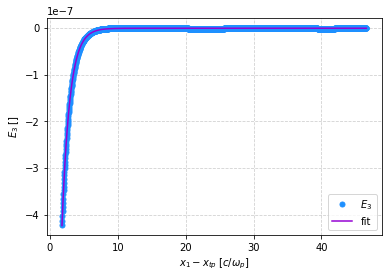

In [13]:
from scipy.optimize import curve_fit

fig=plt.figure();
plt.grid(alpha=0.6,linestyle='dashed')
ax1=plt.gca()
ax1.set_xlabel("$x_1-x_{tp}\;[c/\omega_p]$")
ax1.set_ylabel("$E_3\;[]$")

#retrieve the parameters from the upper boxes
param=ret[1]
par=[i.value for i in param]
#actually fit the data
popt, pcov = curve_fit(Emfun, nxx, ndata,p0=par)

#plot the original data points
ax1.plot(nxx-popt[1],ndata,'.',c="dodgerblue",ms=10,label="$E_3$");


#upate the parameters in the boxes
for i,b in enumerate(popt):
    param[i].value=b

ax1.plot(nxx-popt[1], Emfun(nxx, *popt), '-',c="darkviolet", label='fit')[0]

plt.legend()
plt.show()    

Fit's Results:

In [4]:
betasf=[0.4853,0.8687,0.9421,0.9688,0.9808,0.9854]

From the previous questions, the dispersion relation is given by:
$$\omega^2=\omega_p^2-k^2c^2$$
$$ =>{ \left( \frac{\omega}{\omega_p} \right) }^2 = 1 - {\left( \frac{kc}{\omega_p} \right) }^2 $$

$$=> \beta^2=1-{ \left( \frac{\omega}{\omega_p} \right) }^2$$

In [5]:
betast=[np.sqrt(1-1/(i*i)) for i in range(1,6) ]
#print(betae)

In [6]:
err=[np.abs(betast[i]-betasf[i]) for i in range(0,5)]
for i in range(0,5):
    print("{0:.4f}".format(err[i]))

0.4853
0.0027
0.0007
0.0006
0.0010


Text(0.5,0,'$ kc/ \\omega_p $')

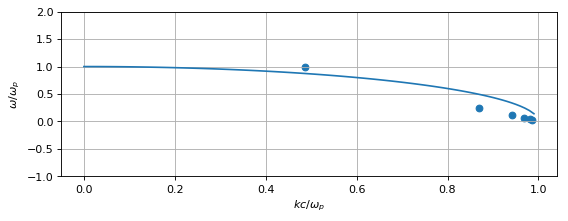

In [30]:
import numpy as np
import math
from matplotlib.pyplot import figure, show
from numpy import arange

beta = arange(0.0, 1.0, 0.01)

fig = figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
ax1 = fig.add_subplot(211)
ax1.plot(beta, np.sqrt(1-beta*beta))
ax1.scatter(betasf,[1,1/(2*2),1/(3*3),1/(4*4),1/(5*5),1/(6*6)])
ax1.grid(True)
ax1.set_ylim((-1, 2))
ax1.set_ylabel('$\omega/\omega_p$')
ax1.set_xlabel('$ kc/ \omega_p $')

For when the density is equal to the critical density k should be zero so we did not not expect the model to work.

For the other values, k appears to be lower than expected this might be due to the fact that in the theoretical prediction.